In [1]:
 
import numpy as np
#x,y是平面坐标系,z是手腕坐标系
joints_3d = np.array([[24.25473, 14.594984, -220.86395],
                      [21.384483, 2.5870495, -102.83917],
                      [2.1389189, 0.4295807, -77.805786],
                      [0.4713831, 4.49901, -45.992554],
                      [24.65406, 7.517185, -131.60638],
                      [20.059254, 10.334126, -121.49127],
                      [14.004571, 31.53947, -106.92682],
                      [0.97307205, 54.702316, -72.0885],
                      [34.38083, 5.5681667, -132.75537],
                      [36.56296, 15.5307255, -122.979614],
                      [34.097603, 38.7413, -104.22839],
                      [23.116486, 59.41091, -62.15027],
                      [40.734467, 13.705656, -126.29144],
                      [48.140816, 5.673216, -115.56366],
                      [52.453285, 28.091465, -97.55463],
                      [41.134747, 46.38981, -56.097656],
                      [38.43096, 12.890821, -117.34686],
                      [44.426872, 1.405302, -101.77527],
                      [50.584797, 10.186543, -84.22754],
                      [255, 255, 51.59436],
                      [0., 0., 0.]], dtype=np.float32)
 
joints_3d_visible = np.array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=np.float32)
 
img_size = [256, 256]
W, H, D = 64, 64, 64
num_joints = 21
mu_x = joints_3d[:, 0] * W / img_size[0]
mu_y = joints_3d[:, 1] * H / img_size[1]
 
print('==mu_x:', mu_x)
print('==mu_y:', mu_y)
 
target = np.zeros([num_joints, H, W], dtype=np.float32)
 
target_weight = joints_3d_visible[:, 0].astype(np.float32)
# print('==target_weight:', target_weight)
target_weight = target_weight * (mu_x >= 0) * (mu_x < W) * (mu_y >= 0) * (mu_y < H)
 
target_weight = target_weight[:, None]
sigma = 2.5
# only compute the voxel value near the joints location
tmp_size = 3 * sigma
 
# get neighboring voxels coordinates
x = y = np.arange(2 * tmp_size + 1, dtype=np.float32) - tmp_size
yy, xx = np.meshgrid(y, x)
 
xx = xx[None, ...].astype(np.float32)  # (1, 2 * tmp_size + 1, 2 * tmp_size + 1,2 * tmp_size + 1, 2 * tmp_size + 1)
yy = yy[None, ...].astype(np.float32)
 
mu_x = mu_x[..., None, None]  # (21, 1, 1)
mu_y = mu_y[..., None, None]
xx, yy = xx + mu_x, yy + mu_y  # (42, 2 * tmp_size + 1, 2 * tmp_size + 1, 2 * tmp_size + 1)
print('==np.min(xx):', np.min(xx))
print('==np.max(xx):', np.max(xx))
# round the coordinates
xx = xx.round().clip(0, W - 1)
yy = yy.round().clip(0, H - 1)
 
# compute the target value near joints
local_target = np.exp(-((xx - mu_x) ** 2 + (yy - mu_y) ** 2) / (2 * sigma ** 2))
print('==local_target.shape:', local_target.shape)
print('==np.max(local_target):', np.max(local_target))
# import pdb;pdb.set_trace()
# put the local target value to the full target heatmap
local_size = xx.shape[1]
idx_joints = np.tile(
    np.arange(num_joints)[:, None, None],
    [1, local_size, local_size])
print('==idx_joints.shape:', idx_joints.shape)
# print("===np.stack([idx_joints, zz, yy, xx],axis=-1)", np.stack([idx_joints, zz, yy, xx], axis=-1).shape)
idx = np.stack([idx_joints, yy, xx], axis=-1).astype(np.long).reshape(-1, 3)
 
target[idx[:, 0], idx[:, 1], idx[:, 2]] = local_target.reshape(-1)
for i in range(num_joints):
    idx = np.unravel_index(np.argmax(target[i], axis=None), target[i].shape)
    print('===i, idx:', i, idx)
print(np.max(target))
print(np.min(target))

==mu_x: [ 6.0636826   5.346121    0.5347297   0.11784577  6.163515    5.0148134
  3.5011427   0.24326801  8.595207    9.14074     8.524401    5.7791214
 10.183617   12.035204   13.113321   10.283687    9.60774    11.106718
 12.646199   63.75        0.        ]
==mu_y: [ 3.648746    0.6467624   0.10739517  1.1247525   1.8792963   2.5835316
  7.8848677  13.675579    1.3920417   3.8826814   9.685325   14.852728
  3.426414    1.418304    7.0228662  11.597452    3.2227054   0.3513255
  2.5466359  63.75        0.        ]
==np.min(xx): -7.5
==np.max(xx): 71.25
==local_target.shape: (21, 16, 16)
==np.max(local_target): 1.0
==idx_joints.shape: (21, 16, 16)
===i, idx: 0 (4, 6)
===i, idx: 1 (1, 5)
===i, idx: 2 (0, 1)
===i, idx: 3 (1, 0)
===i, idx: 4 (2, 6)
===i, idx: 5 (3, 5)
===i, idx: 6 (8, 4)
===i, idx: 7 (14, 0)
===i, idx: 8 (1, 9)
===i, idx: 9 (4, 9)
===i, idx: 10 (10, 9)
===i, idx: 11 (15, 6)
===i, idx: 12 (3, 10)
===i, idx: 13 (1, 12)
===i, idx: 14 (7, 13)
===i, idx: 15 (12, 10)
===i, idx

<ipython-input-1-eb2e7c08c33c>:95: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.stack([idx_joints, yy, xx], axis=-1).astype(np.long).reshape(-1, 3)


http://muyaan.com/2018/10/25/%E7%94%9F%E6%88%90%E4%BA%8C%E7%BB%B4%E9%AB%98%E6%96%AF%E5%88%86%E5%B8%83%E7%83%AD%E5%8A%9B%E5%9B%BE/

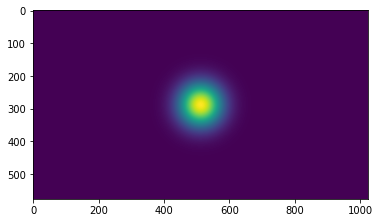

In [2]:
%matplotlib inline
import numpy as np
from math import exp, log, sqrt, ceil
from matplotlib import pyplot as plt

def cal_sigma(dmax, edge_value):
    """Calculate a sigma makes those point's distance to 
    center is dmax value equal to edge value"""
    return sqrt(- pow(dmax, 2) / log(edge_value))

def gaussian(dx, dy, sigma):
    """modifyed version normal distribution pdf"""
    x_term = pow(dx, 2)
    y_term = pow(dy, 2)
    exp_value = - (x_term + y_term) / 2 / pow(sigma, 2)
    return exp(exp_value)

def draw_heatmap(width, height, dmax, x, y, sigma, edge_value):
    heatmap = np.zeros((height, width), dtype=np.float32)
    r = sqrt(2 * pow(dmax, 2))
    intr = int(1.9*dmax)
    xmin = max(0, x - intr)
    xmax = min(width - 1, x + intr)
    ymin = max(0, y - intr)
    ymax = min(height - 1, y + intr)
    for i in range(xmin, xmax):
        for j in range(ymin, ymax):
            dx = x - i
            dy = y - j
            dist = sqrt(pow(dx, 2) + pow(dy, 2))
            if dist > intr:
                continue
            value = gaussian(x - i, y - j, sigma)
            heatmap[j, i] = value
    return heatmap
    
def test():
    dmax = 100
    edge_value = 0.01
    sigma = cal_sigma(dmax, edge_value)
    hm = draw_heatmap(1024, 576, dmax, 512, 288, sigma, edge_value)
    return hm
    
# %timeit hm = test()
hm = test()
plt.imshow(hm)
plt.show()